In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from plot_utils import convert_and_plot 
from matcher import get_good_matches, kNN_matcher
from img_utils import get_direction, get_homography, ransac

from functools import cmp_to_key
from collections import Counter
%matplotlib inline

In [166]:
class Image:
    """
    Each Image object consists of the image, keypoints &
    descriptors.
    """

    def __init__(self, img, kp=None, des=None):
        self.img = img
        self.shape = img.shape
        sift = cv2.xfeatures2d.SIFT_create()

        if kp is None or des is None:
            self.kp, self.des = sift.detectAndCompute(self.img, None)
        else:
            self.kp = kp
            self.des = des

    def __eq__(self, other):
        return (self.img == other.img).all()

    def __hash__(self):
        return hash((tuple(row) for row in self.img))

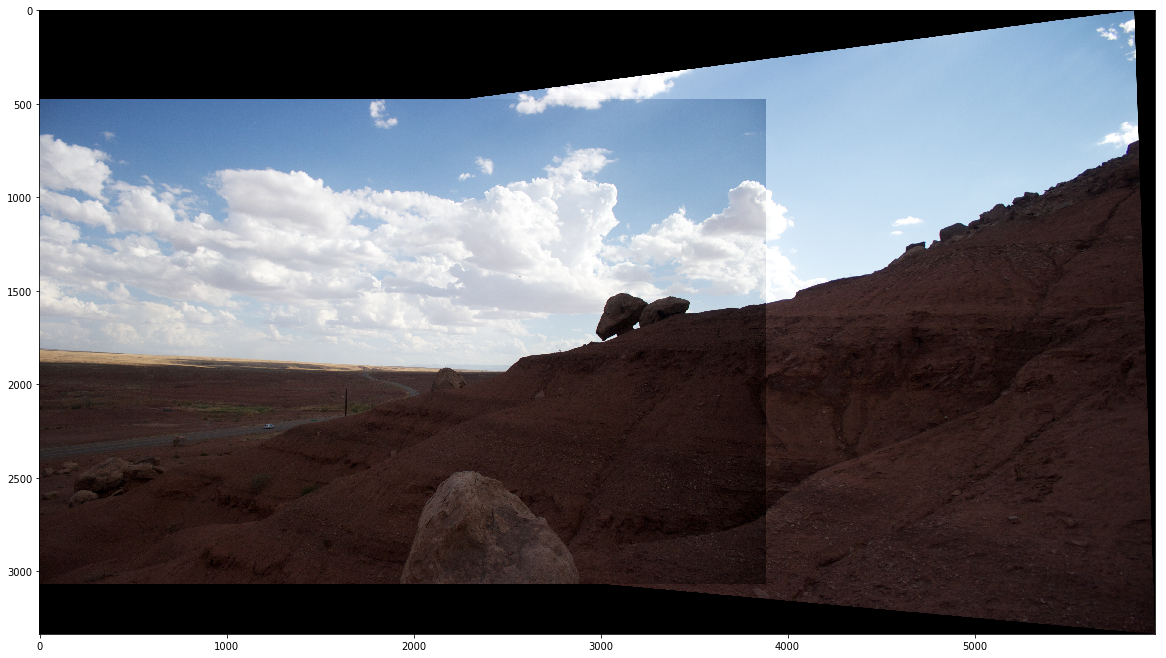

In [214]:
def stitch_images(path_to_directory, verbose=False):
    """
    Input - Path from images should be read from 
    Returns - None

    This function reads the images from the given
    path, aligns it and writes result into panaroma.jpg
    """
    # Get image paths in given directory
    image_paths = glob.glob(path_to_directory + "/*")

    # Read all these images with cv2.imread
    images = [cv2.imread(image_path) 
              for image_path in image_paths 
              if "panaroma" not in image_path]

    # Image dimensions
    h, w, _ = images[0].shape

    # Convert each of these images to Image class
    for i, image in enumerate(images):
        images[i] = Image(image)

    if verbose:
        print("Read", i + 1, "images")

    # Alignment step
    I = sorted(list(set(images)),
               key=cmp_to_key(lambda x, y:
                              get_direction(x.kp, y.kp,
                                            x.des, y.des,
                                            x.img, y.img)))

    # Plot all images if necessary
    if verbose:
        print("Found", i + 1 - len(I), "duplicate images")
        for i in range(len(I)):
            convert_and_plot(I[i].img)

    def warp_two_images(I1, I2, H):
        '''
        warp img2 to img1 with homograph H
        Referred from - https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
        '''
        H /= H[-1, -1]
        h1, w1 = I1.shape[:2]
        h2, w2 = I2.shape[:2]
        pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        pts2_ = cv2.perspectiveTransform(pts2, H)
        pts = np.concatenate((pts1, pts2_), axis=0)
        [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
        t = [-xmin, -ymin]
        Ht = np.array(
            [
                [1, 0, t[0]], 
                [0, 1, t[1]], 
                [0, 0, 1]
            ]
        )  # translate

        result = cv2.warpPerspective(I2.img, 
                                     Ht.dot(H),
                                     (xmax - xmin, ymax - ymin))
        result[t[1]: h1 + t[1], t[0]: w1 + t[0]] = I1.img
        return result
    
    def stitch_2_images(I1, I2):
        if not isinstance(I1, Image):
            I1 = Image(I1)
        if not isinstance(I2, Image):
            I2 = Image(I2)
        matches = get_good_matches(kNN_matcher(I1.des, I2.des))
        H, _ = ransac(matches, I1.kp, I2.kp)
        panaroma = warp_two_images(I1, I2, np.linalg.inv(H))
        return panaroma
    
    assert(2 <= len(I) <= 3)
    if len(I) == 2:
        panaroma = stitch_2_images(I[0], I[1])
        
    else:
        panaroma = stitch_2_images(I[1], I[2])
        panaroma = stitch_2_images(I[0], panaroma)
        
    convert_and_plot(panaroma)
    cv2.imwrite("panaroma.jpg", panaroma)

stitch_images("../data/nevada/", verbose=False)